In [ ]:
import numpy as np
import math
import os
import pandas as pd
from operator import itemgetter
import pickle
from tqdm import tqdm
import scipy
import random
import yaml

import difflib
import string
import json

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
import seaborn as sns


from sklearn.utils import shuffle

import torch
from torch import Tensor
import datasets
from datasets import load_dataset
from embedding import BertHuggingfaceMLM, BertHuggingface
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, RIPA, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias, cossim
from unmasking_bias import PLLBias

from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline, upsample_defining_embeddings, WordVectorWrapper
from transformers import AutoModelForMaskedLM, AutoTokenizer
import time

In [ ]:
titles = ["architect", "psychologist", "professor", "photographer", "journalist", "attorney", "teacher", "dentist", "*software architect", "*writer", "surgeon", "physician", "nurse", "*researcher"]
bios_dataset = BiosDataset(n_folds=5, sel_labels=titles, bios_file="../MeasuringFairnessWithBiasedData/data/BIOS_REVIEWED.pkl")

In [ ]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

attributes = [terms_by_groups[group] for group in groups_by_bias_types['gender']]

## Direct Bias PCA dir

In [ ]:
texts = [sample['text'] for sample in bios_dataset.sel_data]
y = [sample['label'] for sample in bios_dataset.sel_data]
groups = [sample['group'] for sample in bios_dataset.sel_data]

In [ ]:
texts_debiased, _, _ = bios_dataset.get_neutral_samples_by_masking(attributes)

In [ ]:
lm = BertHuggingface(model_name='bert-base-uncased', batch_size=8, num_labels=2)

In [ ]:
emb = lm.embed(texts)

In [270]:
emb_debiased = lm.embed(texts_debiased)

In [271]:
max_emb = min([groups.count(i) for i in [0,1]])

In [272]:
emb_per_group = [[emb[i] for i in range(len(emb)) if groups[i] == group][:max_emb] for group in range(max(groups)+1)]
debiased_per_group = [[emb_debiased[i] for i in range(len(emb_debiased)) if groups[i] == group][:max_emb] for group in range(max(groups)+1)]

In [273]:
attr_emb = np.asarray([lm.embed(attr) for attr in attributes])
attr_emb.shape

(2, 25, 768)

In [274]:
def fit_and_plot_DB(cur_attr_emb, emb_per_group, k=1, savefile='pca_dir.png'):
    print(cur_attr_emb.shape)
    db = DirectBias(k=k)
    db.define_bias_space(cur_attr_emb)
    b_attr = db.bias_space

    db.define_bias_space(np.asarray(emb_per_group))
    b_bios = db.bias_space
    
    print("explained variance: ", db.pca.explained_variance_ratio_[:10])
    
    if b_attr.shape[0] > 1:
        print(b_attr[0,:].shape)
        print("attr/bios cossim: ", np.sum([cossim(b_attr[i,:].flatten(), b_bios[i,:].flatten()) for i in range(b_attr.shape[0])]))
    else:
        print("attr/bios cossim: ", cossim(b_attr.flatten(), b_bios.flatten()))
    
    n_bias_dir = len(cur_attr_emb[0])+1
    corr = np.eye(n_bias_dir, n_bias_dir)
    for i in range(n_bias_dir-1):
        dir_i = cur_attr_emb[0][i] - cur_attr_emb[1][i]
        for j in range(n_bias_dir-1):
            if j > i:
                continue
            #elif j == i:
            #    corr[i,j] = 1
            else:
                dir_j = cur_attr_emb[0][j] - cur_attr_emb[1][j]
                corr[i,j] = cossim(dir_i, dir_j)
        if b_attr.shape[0] > 1:
            corr[-1,i] = np.sum([cossim(dir_i, b_attr[j,:].flatten()) for j in range(b_attr.shape[0])])
        else:
            corr[-1,i] = cossim(dir_i, b_attr.flatten())
        
        
    sns.heatmap(np.abs(corr))
    plt.savefig(savefile)
    plt.show()

(2, 25, 768)
explained variance:  [1.02924356 0.7410268 ]
(768,)
attr/bios cossim:  0.510526484511074


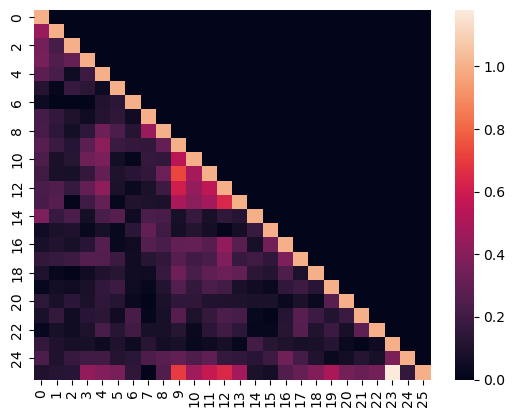

In [275]:
fit_and_plot_DB(attr_emb, emb_per_group, k=2)

(2, 25, 768)
explained variance:  [1.02924356]
attr/bios cossim:  0.103311558929579


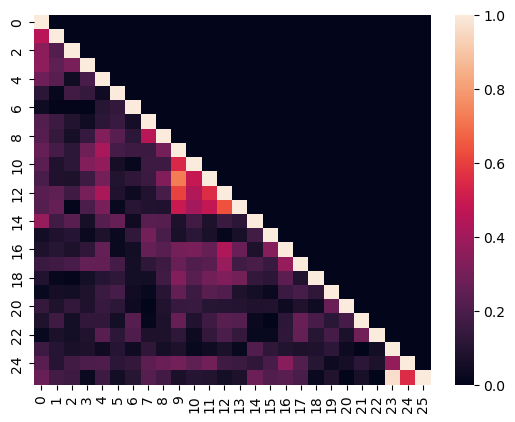

In [276]:
fit_and_plot_DB(attr_emb, emb_per_group)

(2, 23, 768)
explained variance:  [1.02924356]
attr/bios cossim:  -0.06866335665024914


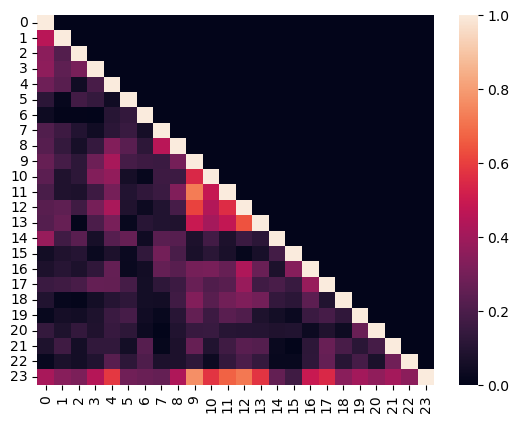

In [277]:
fit_and_plot_DB(attr_emb[:,:23,:], emb_per_group, savefile='pca_dir_23.png')

In [278]:
mean_dir = np.mean(attr_emb[0]-attr_emb[1], axis=0)

In [279]:
cossim(mean_dir, b_attr.flatten())

-0.4862863482195041

In [280]:
cossim(b_attr.flatten(), b_bios.flatten())

0.103311558929579

In [281]:
mean_dir = np.mean(np.asarray(emb_per_group[0])-np.asarray(emb_per_group[1]), axis=0)
cossim(mean_dir, b_bios.flatten())

-0.3596003570035612

## WEAT magntiude comparability

Train BERT on raw/ neutralized texts -> we expect less bias in the latter version (verify with GAP).

In [282]:
def gap_score_one_hot(y_pred: np.ndarray, y_true: np.ndarray, groups: np.ndarray):
    assert len(y_pred.shape) == 2
    assert y_pred.shape == y_true.shape
    n_groups = np.max(groups)+1
    n_samples = y_pred.shape[0]
    n_classes = y_pred.shape[1]
    
    gaps = []
    for c in range(n_classes):
        y_pred_c = y_pred[:,c]
        y_true_c = y_true[:,c]
        
        group_tp = []
        for g in range(n_groups):
            y_pred_cg = [y_pred_c[i] for i in range(n_samples) if groups[i] == g]
            y_true_cg = [y_true_c[i] for i in range(n_samples) if groups[i] == g]
            tp = len([1 for i in range(len(y_pred_cg)) if y_true_cg[i] == 1 and y_pred_cg[i] == 1])/np.sum(y_true_cg)
            group_tp.append(tp)
        
        if n_groups == 2:
            gaps.append(group_tp[0]-group_tp[1])
        else:
            gaps.append(np.var(group_tp))
    return gaps

In [283]:
fold_id = 0
bios_dataset.set_data_split(fold_id)

In [284]:
def count_groups_per_label(y, groups, return_dict=False):
    assert len(y) == len(groups)
    n_groups = max(groups)+1
    n_classes = y.shape[1]
    lookup = {lbl: {group: 0 for group in range(n_groups)} for lbl in range(n_classes)}
    for i in range(len(y)):
        for idx in np.where(y[i] == 1)[0]:
            lookup[idx][groups[i]] += 1
        
    if return_dict:
        return lookup
    
    df = pd.DataFrame(data=lookup)
    return df
            

def resample(X, y, groups):
    df = count_groups_per_label(y,groups)
    print(df)
    
    n_per_group_class = int(np.mean(df))
    print(n_per_group_class)
    
    n_groups = max(groups)+1
    n_classes = y.shape[1]
    n_samples = len(X)
    
    new_X = []
    new_y = []
    new_g = []
    for c in range(n_classes):
        for group in range(n_groups):
            X_cg = [X[i] for i in range(n_samples) if y[i][c] == 1 and groups[i] == group]
            y_cg = [y[i] for i in range(n_samples) if y[i][c] == 1 and groups[i] == group]
            g_cg = [groups[i] for i in range(n_samples) if y[i][c] == 1 and groups[i] == group]
            for i in range(n_per_group_class):
                idx = random.choice(range(len(X_cg)))
                new_X.append(X_cg[idx])
                new_y.append(y_cg[idx])
                new_g.append(g_cg[idx])
             
    print("after resample")
    new_y = np.asarray(new_y)
    df = count_groups_per_label(new_y, new_g)
    print(df)
    
    new_X, new_y = shuffle(new_X, new_y)
    return new_X, new_y

In [344]:
majority_factor = [2.5, 1.2]

def get_classes_by_majority_group(y_train, groups_train):
    sample_dist = count_groups_per_label(y_train, groups_train)
    samples0 = np.sum([sample_dist[job][0] for job in sample_dist.keys()])
    samples1 = np.sum([sample_dist[job][1] for job in sample_dist.keys()])
    
    # partitioning for WEAT
    classes_by_majority_group = {0: [], 1: []}
    for job, dist in sample_dist.items():
        #rel_num0 = dist[0]/samples0
        #rel_num1 = dist[1]/samples1
        #if rel_num0 > majority_factor[0]*rel_num1:
        #    classes_by_majority_group[0].append(job)
        #elif rel_num1 > majority_factor[1]*rel_num0:
        #    classes_by_majority_group[1].append(job)
        if dist[0] > majority_factor[0]*dist[1]:
            classes_by_majority_group[0].append(job)
        elif dist[1] > majority_factor[1]*dist[0]:
            classes_by_majority_group[1].append(job)

    print("classes per majority group: ")
    print(classes_by_majority_group)
    
    return classes_by_majority_group

PUNCTUATION = string.punctuation.replace('-','')
def simplify_text(text: str):
    return text.strip().lower().translate(str.maketrans('', '', PUNCTUATION))

In [345]:
titles_raw = [simplify_text(title) for title in titles]
print(titles_raw)

['architect', 'psychologist', 'professor', 'photographer', 'journalist', 'attorney', 'teacher', 'dentist', 'software architect', 'writer', 'surgeon', 'physician', 'nurse', 'researcher']


In [346]:
y_train = np.asarray([sample['label'] for sample in bios_dataset.train_data])
groups = [sample['group'] for sample in bios_dataset.train_data]

n_classes = len(titles)
n_groups = 2
mean_n_samples = len(bios_dataset.train_data)/(n_classes*n_groups) # per class
sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.train_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
print("train data stats for fold ", fold_id)
print(df)
class_gender_weights = {g: {lbl: mean_n_samples/df.loc[g,lbl] for lbl in bios_dataset.labels} for g in bios_dataset.sel_groups}
# for each class: number of negative samples over number of positive samples -> pos weight
class_weights = [(len(bios_dataset.train_data)-np.sum(df.loc[:,lbl]))/np.sum(df.loc[:,lbl]) for lbl in bios_dataset.labels]
print("class weights: ", class_weights)

classes_by_majority_group = get_classes_by_majority_group(y_train, groups)
print("classes by majority group: ", classes_by_majority_group)

train data stats for fold  0
        architect  psychologist  professor  photographer  journalist  \
male          215           322        211           954         760   
female         74           469        178           465         725   

        attorney  teacher  dentist  *software architect  *writer  surgeon  \
male         723      434       82                  140      356      766   
female       437      609       46                   14      371       97   

        physician  nurse  *researcher  
male          629     39          152  
female        353    481           69  
class weights:  [29.134948096885815, 10.010113780025284, 21.388174807197945, 5.137420718816068, 4.864646464646465, 6.507758620689655, 7.349952061361457, 67.0390625, 55.55194805194805, 10.979367262723521, 9.09154113557358, 7.868635437881874, 15.748076923076923, 38.40723981900452]
classes per majority group: 
{0: [0, 8, 10], 1: [1, 6, 12]}
classes by majority group:  {0: [0, 8, 10], 1: [1, 6, 12]}


In [335]:
def plot_violin(target_bias, classes_by_majority_group, title, xlabel, save=None):
    labels = ['stereo male', 'stereo female']
    fig, ax = plt.subplots()
    data = [[target_bias[i] for i in classes_by_majority_group[g]] for g in [0,1]]
    ax.vlines(0,0.25, len(labels) + 0.75, 'grey', '--', linewidths=0.8)
    ax.violinplot(data, vert=False)
    ax.set_xlabel(xlabel)
    ax.set_yticks(np.arange(1, len(data) + 1), labels=labels)
    xmax = np.max(np.abs(ax.get_xlim()))
    ax.set_xlim(-xmax, xmax)
    ax.set_title(title)
    plt.tight_layout()
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

In [336]:
bios_dataset.sel_groups

['male', 'female']

In [317]:
## attribute diff
def test_attribute_emb(model_name):
    batch_size = 8
    if 'gpt' in model_name:
        batch_size = 1
    lm = BertHuggingface(model_name=model_name, batch_size=batch_size, num_labels=2)
    attr_emb = [lm.embed(attr) for attr in attributes]
    attr_len = 0.5*(np.mean(np.linalg.norm(attr_emb[0], axis=1))+np.mean(np.linalg.norm(attr_emb[1], axis=1)))
    #sample_len = np.mean(np.linalg.norm(target_emb_all, axis=1))
    attr_diff = [np.asarray(attr_emb[0])-np.asarray(attr_emb[1])]
    mean_attr_diff = np.mean(np.linalg.norm(attr_diff, axis=1))

    return attr_len, mean_attr_diff

models = ['openai-gpt', 'gpt2', 'GroNLP/hateBERT', 'bert-large-uncased', 'bert-base-uncased', 'bert-large-uncased', 'distilbert-base-uncased', 'roberta-base', 
          'distilroberta-base', 'bert-large-uncased-whole-word-masking', 'google/electra-base-generator', 'albert-base-v2', 'xlnet-base-cased']
res = {'attr_len': {}, 'attr_diff': {}}
for model in models:
    attr_len, mean_attr_diff = test_attribute_emb(model)
    res['attr_len'][model] = attr_len
    res['attr_diff'][model] = mean_attr_diff
df = pd.DataFrame(data=res)
df

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-generator and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using Bert with CUDA/GPU


,attr_len,attr_diff
openai-gpt,12.297693,0.727554
gpt2,92.565994,0.842267
GroNLP/hateBERT,9.891623,0.949508
bert-large-uncased,13.982952,1.123193
bert-base-uncased,8.870663,0.567524
distilbert-base-uncased,8.352082,0.433000
roberta-base,10.950019,0.234675
distilroberta-base,13.376940,0.197752
bert-large-uncased-whole-word-masking,16.082165,1.631741
google/electra-base-generator,6.333381,0.517918


In [342]:
def evaluate_model_bias(model_name, save_fig=False, targets=None, targets_by_group=None):
    print("###########################################")
    print("###### Evaluate "+model_name+" ############")
    print("###########################################")
    batch_size = 8
    if 'gpt' in model_name:
        batch_size = 1
    lm = BertHuggingface(model_name=model_name, batch_size=batch_size, num_labels=2) #roberta-base , distilbert-base-uncased
    emb_size = lm.model.config.hidden_size

    attr_emb = [lm.embed(attr) for attr in attributes]
    target_emb_all = lm.embed([sample['text'] for sample in bios_dataset.sel_data])
    title_emb = lm.embed(titles_raw)
    
    print("mean len of attribute emb: ", 0.5*(np.mean(np.linalg.norm(attr_emb[0], axis=1))+np.mean(np.linalg.norm(attr_emb[1], axis=1))))
    print("mean len of sample emb: ", np.mean(np.linalg.norm(target_emb_all, axis=1)))
    attr_diff = [np.asarray(attr_emb[0])-np.asarray(attr_emb[1])]
    print("mean attr diff: ", np.mean(np.linalg.norm(attr_diff, axis=1)))

    train_ids = [sample['id'] for sample in bios_dataset.train_data]
    emb_train = np.asarray([target_emb_all[i] for i in train_ids])
    y_train = np.asarray([sample['label'] for sample in bios_dataset.train_data])
    groups = [sample['group'] for sample in bios_dataset.train_data]

    test_ids = [sample['id'] for sample in bios_dataset.eval_data]
    emb_test = np.asarray([target_emb_all[i] for i in test_ids])
    y_test = np.asarray([sample['label'] for sample in bios_dataset.eval_data])
    groups_test = [sample['group'] for sample in bios_dataset.eval_data]
    
    parameters = {'optimizer': 'RMSprop', 'criterion': 'BCEWithLogitsLoss', 'lr': 1e-4, 'epochs': 5, 'batch_size': 8}
    head = SimpleCLFHead(input_size=emb_size, output_size=len(titles))#, hidden_size=emb_size)
    clf = CustomModel(parameters, head, class_weights=class_weights)
    clf.set_lr(parameters['lr'])
    clf.fit(emb_train, y_train, epochs=parameters['epochs'])#, weights=w_train)
    pred = clf.predict(emb_test)
    y_pred = (np.array(pred) >= 0.5).astype(int)
    score = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print("f1:", score)
    print("recall:", recall)
    gaps = gap_score_one_hot(y_pred, y_test, groups_test)
    print("gaps: ", gaps)
    print("mean gap: ", np.mean(np.abs(gaps)))

    weat = WEAT()
    weat.define_bias_space(attr_emb)
    weat_scores = [weat.individual_bias(e) for e in emb_test]

    weat_word = [weat.individual_bias(te) for te in title_emb]
    print("titles WEAT scores: ", weat_word)

    max_emb = min([groups_test.count(i) for i in [0,1]])
    emb_per_group = [[emb_test[i] for i in range(len(emb_test)) if groups_test[i] == group][:max_emb] for group in range(max(groups_test)+1)]

    target_emb_per_group = []
    for group in range(max(groups_test)+1):
        group_emb = []
        for i in range(len(y_test)):
            for lbl in classes_by_majority_group[group]:
                if y_test[i][lbl] == 1:
                    group_emb.append(emb_test[i])
        target_emb_per_group.append(group_emb)
    eff_size = weat.group_bias(target_emb_per_group)
    print("effect size: ", eff_size)

    print("titles used: ", [[titles_raw[i] for i in classes_by_majority_group[g]] for g in classes_by_majority_group.keys()])
    titles_per_group = [[titles[i] for i in classes_by_majority_group[g]] for g in classes_by_majority_group.keys()]
    title_emb_per_group = [lm.embed(group_titles) for group_titles in titles_per_group]
    eff_word = weat.group_bias(title_emb_per_group)
    print("effect size (titles): ", eff_word)
    
    if save_fig:
        plot_violin(weat_word, classes_by_majority_group, title='WEAT sample bias (Effect Size: %0.2f)' % (eff_word), xlabel='s(t,A,B)', save=model_name+"_weat.png")
        plot_violin(gaps, classes_by_majority_group, title='GAP scores', xlabel='GAP_c', save=model_name+"_gaps.png")
    else:
        plot_violin(weat_word, classes_by_majority_group, title='WEAT sample bias (Effect Size: %0.2f)' % eff_word, xlabel='s(t,A,B)')
        plot_violin(gaps, classes_by_majority_group, title='GAP scores', xlabel='GAP_c')
    
    #fig, ax = plt.subplots(2, 1, figsize=(10,5))
    #ax[0].hist(weat_scores)
    #ax[0].set_title('BIOS emb, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f' % (np.mean(np.abs(gaps)), np.std(np.abs(gaps)), eff_size))
    
    #ax[1].hist(weat_word)
    #ax[1].set_title('Title emb, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f' % (np.mean(np.abs(gaps)), np.std(np.abs(gaps)), eff_word))
    #plt.show()
    print()

###########################################
###### Evaluate openai-gpt ############
###########################################


Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU
mean len of attribute emb:  12.297693252563477
mean len of sample emb:  10.907939
mean attr diff:  0.72755367
use class weights
f1: 0.6312355770787585
recall: 0.7671558905196351
gaps:  [0.35000000000000003, -0.1752380952380952, 0.06568627450980391, 0.06055776892430276, -0.004728492983526511, 0.0372192162649615, -0.3070544554455445, 0.19090909090909092, 0.30107526881720437, 0.11625884983231904, 0.20369170984455953, 0.21904761904761905, -0.5272727272727273, 0.489010989010989]
mean gap:  0.21769646843576743
titles WEAT scores:  [-0.015554351202120675, -0.017147057297995594, -0.00837062326857263, -0.020568915906598262, -0.016536556733552255, -0.017452657836091068, -0.016700382935499358, -0.01491651187873555, -0.01705754723964059, -0.0166843630473541, -0.01983369199748286, -0.01799562236310448, -0.017809654465531066, -0.017476372386982852]
effect size:  -0.5939306853153151
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 'teacher', 'nu

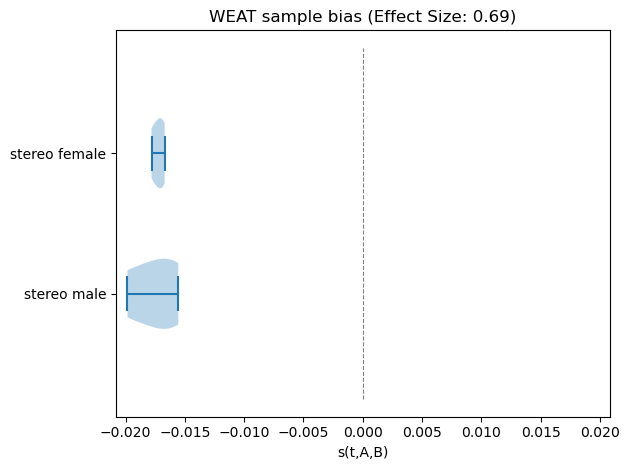

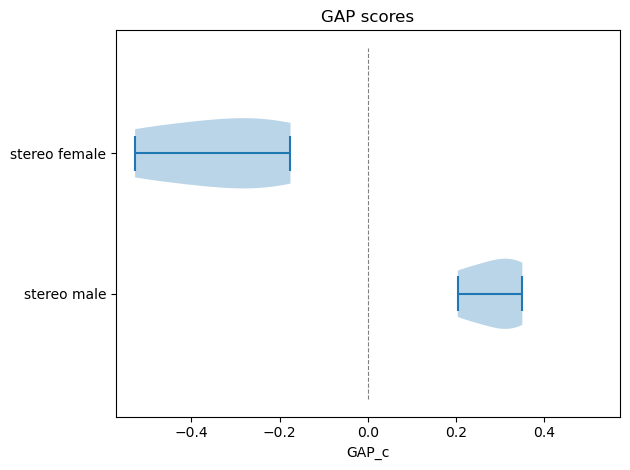

In [350]:
evaluate_model_bias('openai-gpt', save_fig=True)

###########################################
###### Evaluate gpt2 ############
###########################################


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU
mean len of attribute emb:  92.56599426269531
mean len of sample emb:  212.72649
mean attr diff:  0.84226656
use class weights
f1: 0.6583136981981564
recall: 0.768345894486315
gaps:  [0.2692307692307693, -0.1669841269841269, 0.1588235294117647, 0.04256818878332824, 0.017998779743746196, 0.0991419358364759, -0.3696163366336634, 0.2575757575757576, 0.23655913978494625, 0.07862377344429261, 0.13082901554404147, 0.1995590828924162, -0.5024793388429751, 0.23076923076923073]
mean gap:  0.19719707181982393
titles WEAT scores:  [-0.0006789793417710799, -0.0012205139907299767, -0.0007625819341313678, -0.0007940887045527756, -0.0012517550694037816, -0.0009434707777487006, -0.0007186669915787425, -0.0021248777359659243, -0.0005491215003924355, 0.0026631259248590666, -0.0006295314538332653, -0.0011632326371902035, -0.0008054949782192455, -0.001241066985219419]
effect size:  0.2548072575057702
titles used:  [['architect', 'professor', 'photographer', 'journalist', 'attorney

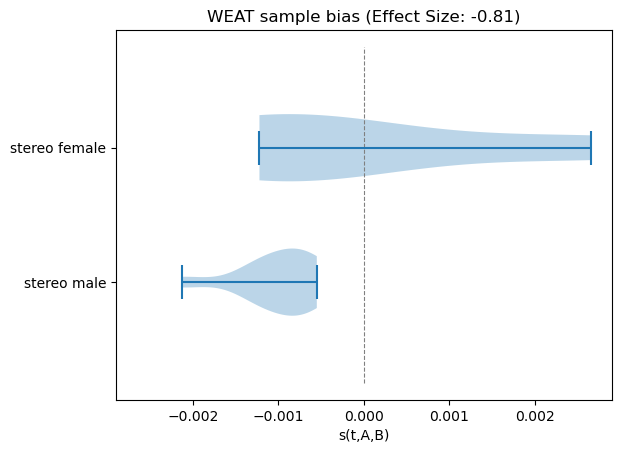

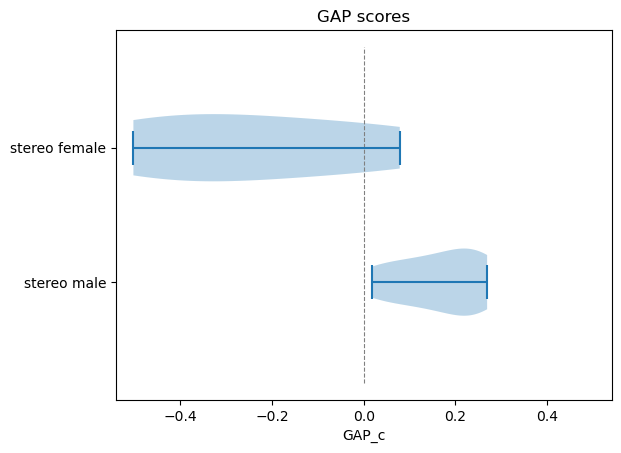

In [302]:
evaluate_model_bias('gpt2', save_fig=True)

In [ ]:
evaluate_model_bias('GroNLP/hateBERT')

###########################################
###### Evaluate bert-base-cased ############
###########################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  13.987003326416016
mean len of sample emb:  9.80308
mean attr diff:  0.8084159
use class weights
f1: 0.6499296372001067
recall: 0.7326457754859182
gaps:  [0.3346153846153846, -0.14317460317460318, 0.0235294117647058, 0.057676984370211404, 0.026662599145820587, 0.10378750614854892, -0.2920173267326733, 0.23333333333333334, 0.17204301075268824, 0.16258849832318967, 0.14119170984455953, 0.17495590828924168, -0.7024793388429752, 0.3021978021978022]
mean gap:  0.2050181012525527
titles WEAT scores:  [0.0030962072246871752, -0.00047595880539619273, 0.0006303978577542058, 0.004529700086319255, -0.006097350122691747, 0.00908609028178442, -0.0035740254403239247, -0.009814453905734433, -0.0036311538347495453, 0.008938537204332464, 0.015922723535851446, 0.011481258451013554, 0.0038997757406289413, -0.00043202419616739096]
effect size:  1.0730033002227828
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 'teacher', 

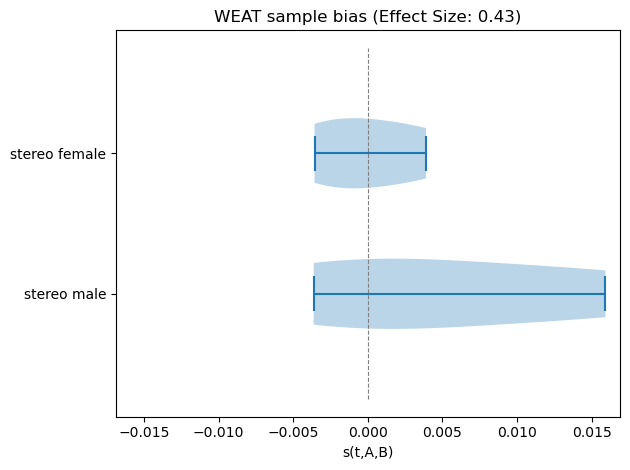

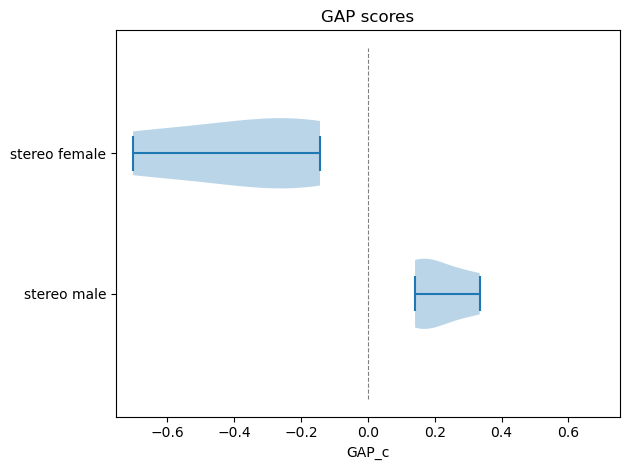

In [354]:
evaluate_model_bias('bert-base-cased')

In [355]:
evaluate_model_bias('bert-large-cased')

###########################################
###### Evaluate bert-large-cased ############
###########################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.91 GiB total capacity; 8.44 GiB already allocated; 20.12 MiB free; 9.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
evaluate_model_bias('bert-large-uncased-whole-word-masking')

In [ ]:
evaluate_model_bias('bert-large-uncased')

###########################################
###### Evaluate bert-base-uncased ############
###########################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  8.870662689208984
mean len of sample emb:  8.629654
mean attr diff:  0.5675244
use class weights
f1: 0.6755607221005914
recall: 0.7945259817532725
gaps:  [0.3076923076923077, -0.01777777777777778, 0.0019607843137255943, 0.05136377566656447, -0.007107992678462516, 0.08045034705142917, -0.313799504950495, 0.1454545454545454, 0.30107526881720437, 0.10768848590237234, 0.1878238341968912, 0.22169312169312172, -0.6685950413223141, 0.23076923076923073]
mean gap:  0.18880371559188872
titles WEAT scores:  [0.001572006036572593, -0.0033531720928183795, 0.0014807136245648111, -0.0035635339201980365, 0.0007111360009656176, -0.00014383442555931936, -0.004681079445956415, -0.0035799145743560246, -0.0025613318237568405, -0.005259886482569143, -0.002078501094086027, -0.00047038398520571345, -0.010939725683091539, -0.002527039294986655]
effect size:  0.9746089315732633
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 't

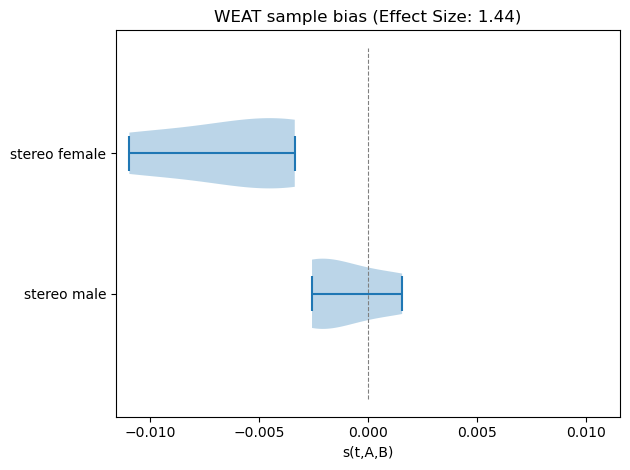

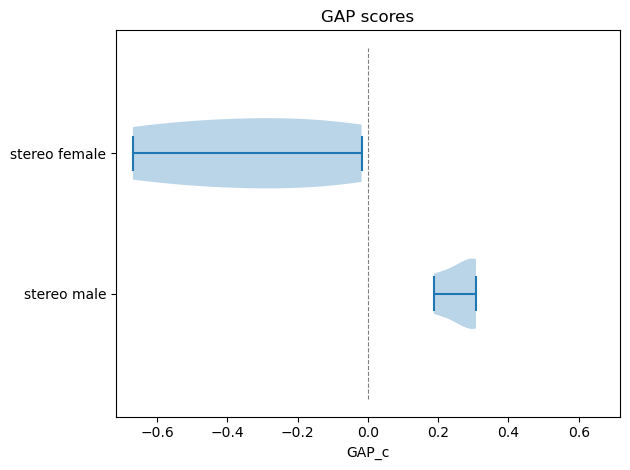

In [347]:
evaluate_model_bias('bert-base-uncased')

###########################################
###### Evaluate distilbert-base-uncased ############
###########################################


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  8.352082252502441
mean len of sample emb:  7.7696247
mean attr diff:  0.43300033
use class weights
f1: 0.6710543005235634
recall: 0.7873859579531932
gaps:  [0.34615384615384615, -0.09206349206349207, -0.022549019607843168, 0.05136377566656447, 0.019951189749847442, 0.1201836366617478, -0.3393564356435644, 0.2121212121212121, 0.6344086021505377, 0.13352378586510993, 0.17746113989637302, 0.18985890652557325, -0.7016528925619835, 0.3406593406593407]
mean gap:  0.24152194823764545
titles WEAT scores:  [-0.006535623296792248, -0.009555712645421877, -0.0002603782295780288, -0.007064095214943333, -0.00918808377393332, -0.0044896411157456795, -0.008500311314071918, -0.004019712443599888, -0.006525523886467655, -0.009850865596292224, -0.0035687141272103817, -0.007109560219944799, -0.016730505647296945, -0.009087206558089256]
effect size:  0.9795369788696255
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 'teach

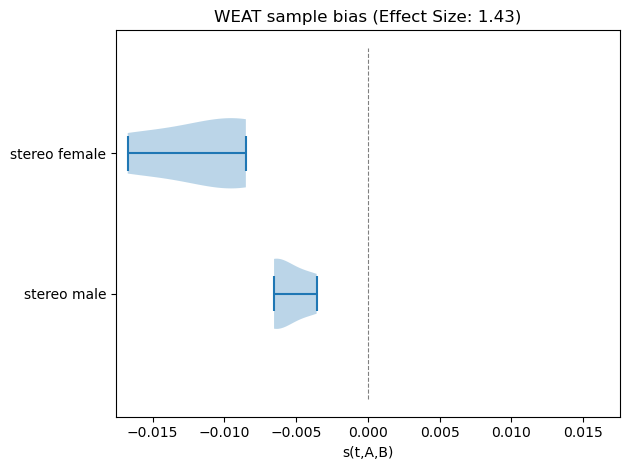

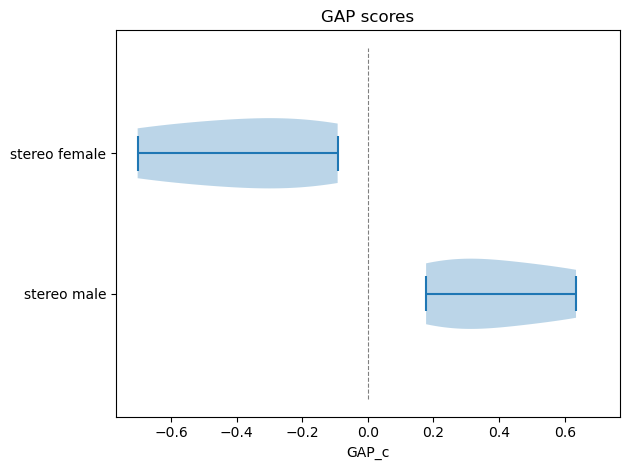

In [348]:
evaluate_model_bias('distilbert-base-uncased', save_fig=True)

###########################################
###### Evaluate roberta-base ############
###########################################


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  10.950018882751465
mean len of sample emb:  12.523774
mean attr diff:  0.23467536
use class weights
f1: 0.6272996938250159
recall: 0.6299087663625546
gaps:  [0.1653846153846154, -0.18380952380952376, 0.10882352941176476, 0.08308305240576164, 0.043349603416717564, 0.12707001147729136, -0.3113861386138614, 0.2090909090909091, 0.13978494623655913, 0.15215501179977642, 0.052784974093264214, 0.18994708994708992, -0.4380165289256198, 0.14285714285714285]
mean gap:  0.16768164839070693
titles WEAT scores:  [-0.0006361427826001576, -0.0012355228191608392, -0.0009466147435933658, -0.0004326384128264804, -0.001207060868180898, -0.0005346759294564407, -0.000997204968259613, -0.0011093521472167467, -0.0004632432050825086, 0.0005268385701006073, -0.0005527964065626945, -0.0006532813961700468, -0.0001843604504073726, -0.0007112187275204462]
effect size:  0.7963820690170909
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologi

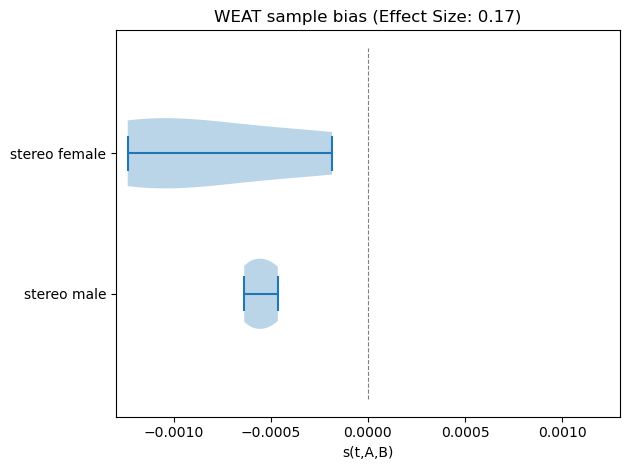

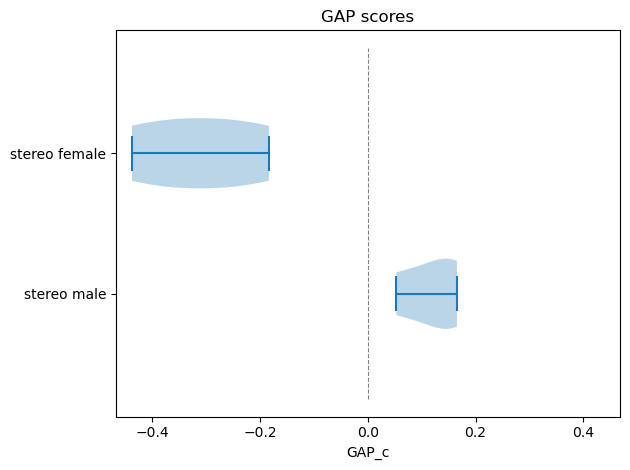

In [349]:
evaluate_model_bias('roberta-base')

In [ ]:
evaluate_model_bias('distilroberta-base')

###########################################
###### Evaluate google/electra-base-generator ############
###########################################


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-generator and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  6.333380699157715
mean len of sample emb:  4.862657
mean attr diff:  0.5179175
use class weights
f1: 0.33846856143858717
recall: 0.2721142403808013
gaps:  [0.0, -0.007936507936507936, 0.00392156862745098, -0.0157217284707325, 0.04905430140329464, 0.14067879980324643, 0.0, 0.0, 0.06451612903225806, 0.013787107191653212, 0.02266839378238339, 0.20634920634920634, -0.008264462809917356, 0.043956043956043966]
mean gap:  0.041203874954478206
titles WEAT scores:  [0.0001865307136240668, 0.006776513654622063, 0.0044249026190135154, -0.0009915649564057327, 0.0013180324109974828, -3.960421353732535e-05, 4.548861501330048e-05, 0.003364701666733083, -0.00023045391157883177, -0.005681614389314471, 0.0013420123734800837, 0.0027659770660618532, -0.008129003479613317, 0.0026856887524407957]
effect size:  0.7246897064426787
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 'teacher', 'nurse']]
effect size (titles):  0.40

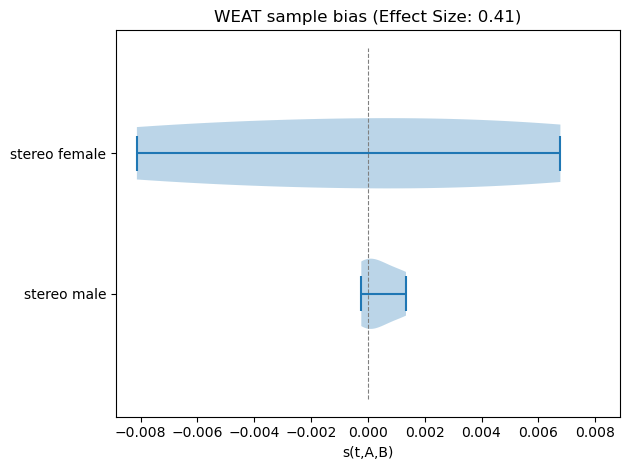

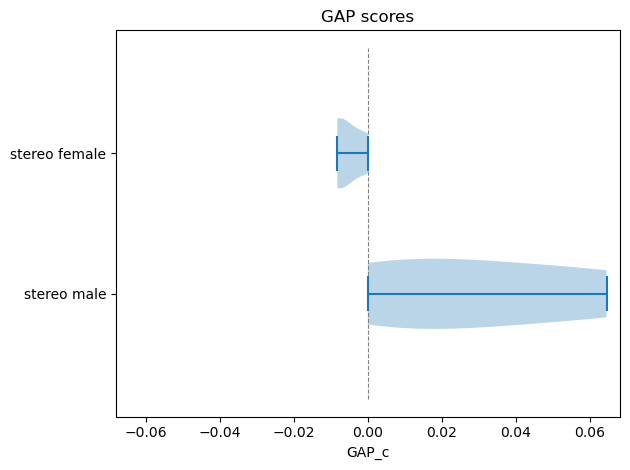

In [351]:
evaluate_model_bias('google/electra-base-generator')

###########################################
###### Evaluate albert-base-v2 ############
###########################################


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  12.958805084228516
mean len of sample emb:  19.191307
mean attr diff:  1.1260438
use class weights
f1: 0.6113808760430921
recall: 0.7560491868306227
gaps:  [0.19615384615384612, -0.09523809523809523, 0.0607843137254902, 0.12430278884462143, 0.015405735204392923, 0.10263977701262506, -0.21225247524752477, 0.16666666666666669, 0.20430107526881724, 0.1333995776922121, 0.10492227979274615, 0.15414462081128755, -0.35289256198347113, 0.19780219780219788]
mean gap:  0.15149328653171387
titles WEAT scores:  [-0.02491678194503072, 0.04186227628659056, -0.0661379114354661, 0.047719945975915445, -0.021273639491229956, 0.04664241278823511, -0.07369468327095241, 0.04081178504795302, -0.058442768876666884, 0.035609364148657896, -0.047291109220219285, -0.04511353389783057, -0.07346913758151635, -0.025423182287343582]
effect size:  1.0962735878951557
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 'teacher', 'nurse']]

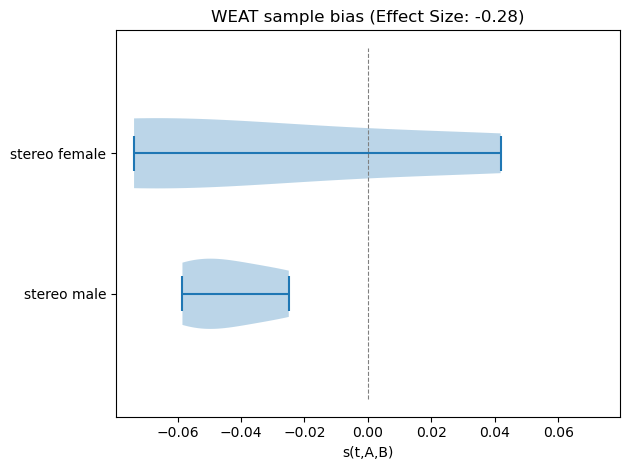

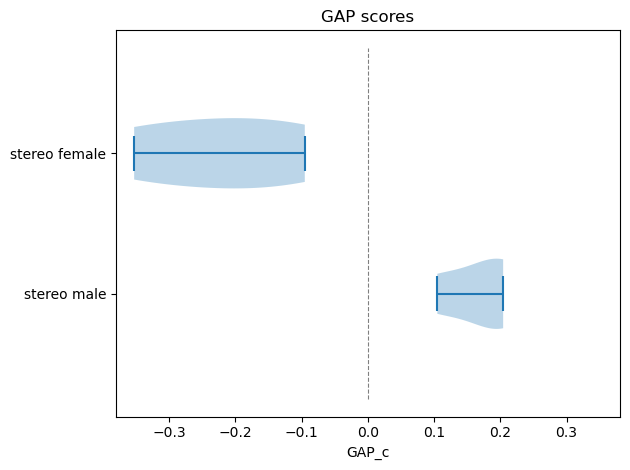

In [352]:
evaluate_model_bias('albert-base-v2')

###########################################
###### Evaluate xlnet-base-cased ############
###########################################


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using Bert with CUDA/GPU
mean len of attribute emb:  136.70742797851562
mean len of sample emb:  71.99551
mean attr diff:  5.206437
use class weights
f1: 0.6732413268987
recall: 0.7897659658865529
gaps:  [0.23076923076923084, -0.02571428571428569, 0.08235294117647052, 0.08927367453263868, 3.0506406345387482e-05, 0.05820626332185608, -0.2898514851485149, 0.12727272727272732, 0.6021505376344085, 0.02869208793938649, 0.22959844559585496, 0.1385361552028218, -0.7099173553719008, 0.19780219780219788]
mean gap:  0.20072627813490285
titles WEAT scores:  [0.005158707295523368, -0.0007372232876274865, 0.00019226917905212915, -0.001763157395117676, -0.002707614911869549, -0.003622046036193427, -0.0004480566208926451, 0.0010948250337343701, 0.003879186417335867, 0.0005350604769412959, 0.0009909099645846187, -0.0001713903452124077, -0.0014883006132995202, -0.0025198834888009447]
effect size:  0.3306132639024517
titles used:  [['architect', 'software architect', 'surgeon'], ['psychologist', 'teache

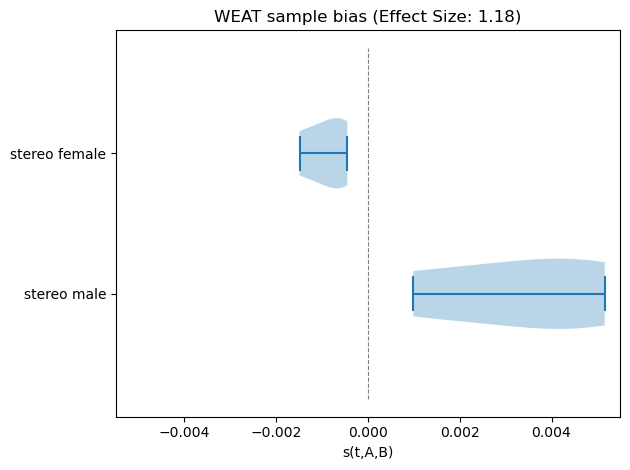

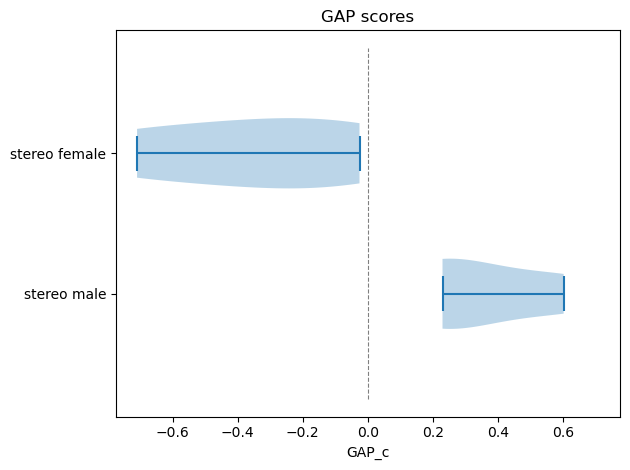

In [353]:
evaluate_model_bias('xlnet-base-cased')

In [ ]:
def train_eval(fold_id, neutralize=False, epochs=1):
    lm = BertHuggingface(model_name='bert-base-uncased', batch_size=8, num_labels=len(bios_dataset.labels))
    
    bios_dataset.set_data_split(fold_id)
    
    y_train = np.asarray([sample['label'] for sample in bios_dataset.train_data])
    groups_train = [sample['group'] for sample in bios_dataset.train_data]
    y_test = np.asarray([sample['label'] for sample in bios_dataset.eval_data])
    groups_test = [sample['group'] for sample in bios_dataset.eval_data]
    classes_by_majority_group = get_classes_by_majority_group(y_train, groups_train)
    
    if neutralize:
        X_train = [sample['counterfactual'] for sample in bios_dataset.train_data]
        #X_test = [sample['counterfactual'] for sample in bios_dataset.eval_data]
        X_train, y_train = resample(X_train, y_train, groups_train)
    else:
        X_train = [sample['text'] for sample in bios_dataset.train_data]
    X_test = [sample['counterfactual'] for sample in bios_dataset.eval_data]
    
    lm.retrain(X_train, y_train, epochs=epochs)
    pred = lm.predict(X_test)
    y_pred = (np.array(pred) >= 0.5).astype(int)
    score = f1_score(y_test, y_pred, average='weighted')
    gaps = gap_score_one_hot(y_pred, y_test, groups_test)
    
    attr_emb = np.asarray([lm.embed(attr) for attr in attributes])
    emb = lm.embed(X_test)

    weat = WEAT()
    weat.define_bias_space(attr_emb)
    weat_scores = [weat.individual_bias(e) for e in emb]
    
    titles_raw = [simplify_text(title) for title in titles]
    print(titles_raw)
    title_emb = lm.embed(titles_raw)
    weat_word = [weat.individual_bias(te) for te in title_emb]
    
    max_emb = min([groups_test.count(i) for i in [0,1]])
    emb_per_group = [[emb[i] for i in range(len(emb)) if groups_test[i] == group][:max_emb] for group in range(max(groups_test)+1)]
    
    target_emb_per_group = []
    for group in range(max(groups_test)+1):
        group_emb = []
        for i in range(len(y_test)):
            for lbl in classes_by_majority_group[group]:
                if y_test[i][lbl] == 1:
                    group_emb.append(emb[i])
        target_emb_per_group.append(group_emb)
    eff_size = weat.group_bias(target_emb_per_group)
    
    titles_per_group = [[titles[i] for i in classes_by_majority_group[g]] for g in classes_by_majority_group.keys()]
    title_emb_per_group = [lm.embed(group_titles) for group_titles in titles_per_group]
    eff_word = weat.group_bias(title_emb_per_group)
    
    res = {'f1': score, 'GAPs': gaps, 'sample_bias': weat_scores, 'weat_word': weat_word, 'eff_size_word': eff_word, 'eff_size': eff_size}
    
    return res


In [ ]:
results = []
results_debias = []
for i in range(2):
    results.append(train_eval(fold_id=i, neutralize=False, epochs=2))
    results_debias.append(train_eval(fold_id=i, neutralize=True, epochs=2))

In [ ]:
fig, ax = plt.subplots()
xs = np.arange(len(gaps[0]))
ax.bar(xs, np.mean(gaps, axis=0))
ax.set_xticks(xs, titles, rotation=90)
plt.show()

In [ ]:
sel_classes = [6,8,12,13]
weat_extreme = []
weat_extreme_d = []
stereo_label = []
for fold_id in range(5):
    bios_dataset.set_data_split(fold_id)
    
    y_train = np.asarray([sample['label'] for sample in bios_dataset.train_data])
    groups_train = [sample['group'] for sample in bios_dataset.train_data]
    y_test = np.asarray([sample['label'] for sample in bios_dataset.eval_data])
    groups_test = [sample['group'] for sample in bios_dataset.eval_data]
    classes_by_majority_group = get_classes_by_majority_group(y_train, groups_train)
        
    sample_bias = np.asarray(results[fold_id]['sample_bias'])
    sample_bias_d = np.asarray(results_debias[fold_id]['sample_bias'])
    
    weat_extreme = sample_bias
    weat_extreme_d = sample_bias_d
    for i in range(y_test.shape[0]):
        stereo_groups = []
        for c in range(y_test.shape[1]):
            if y_test[i,c] == 1:
                if c in classes_by_majority_group[0]:
                    stereo_groups.append(0)
                else:
                    stereo_groups.append(1)
        if stereo_groups.count(0) > stereo_groups.count(1):
            stereo_label.append(0)
        else:
            stereo_label.append(1)

            
"""                  
    weat = []
    weat_d = []
    for i in range(y_test.shape[0]):
        stereo_groups = []
        for c in sel_classes:
            if y_test[i,c] == 1:
                weat.append(sample_bias[i])
                weat_d.append(sample_bias_d[i])
                if c in classes_by_majority_group[0]:
                    stereo_groups.append(0)
                else:
                    stereo_groups.append(1)
        if stereo_groups.count(0) > stereo_groups.count(1):
            stereo_label.append(0)
        else:
            stereo_label.append(1)
    
#    stereo_label +=
            
    weat_extreme += weat
    weat_extreme_d += weat_d"""

In [ ]:
stereo_label.count(0)

In [ ]:
bios_dataset.sel_data[0]

In [ ]:
weat_0 = [weat_extreme[i] for i in range(len(weat_extreme)) if stereo_label[i] == 0]
weat_1 = [weat_extreme[i] for i in range(len(weat_extreme)) if stereo_label[i] == 1]
weat_d0 = [weat_extreme_d[i] for i in range(len(weat_extreme_d)) if stereo_label[i] == 0]
weat_d1 = [weat_extreme_d[i] for i in range(len(weat_extreme_d)) if stereo_label[i] == 1]

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(9,6))
ax[0].hist(weat_0, label='stereo male')
ax[0].hist(weat_1, label='stereo female')
ax[0].set_title('Raw data, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f (+/- %0.3f)' % (np.mean(np.abs(gaps)), np.std(np.abs(gaps)), np.mean(effect_sizes), np.std(effect_sizes)))
ax[1].hist(weat_d0, label='stereo male')
ax[1].hist(weat_d1, label='stereo female')
ax[1].legend()
ax[1].set_title('Debiased, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f (+/- %0.3f)' % (np.mean(np.abs(gaps_d)), np.std(np.abs(gaps_d)), np.mean(effect_sizes_d), np.std(effect_sizes_d)))

max_y = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
max_x = max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])
min_x = max(ax[0].get_xlim()[0], ax[1].get_xlim()[0])
ax[0].set_xlim(min_x, max_x)
ax[1].set_xlim(min_x, max_x)
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

In [ ]:
results_debias[0]['eff_size_word']-results[0]['eff_size_word']

In [ ]:
np.asarray(results_debias[0]['GAPs'])-np.asarray(results[0]['GAPs'])

In [ ]:
gaps = [res['GAPs'] for res in results]
gaps_d = [res['GAPs'] for res in results_debias]

weat_scores = []
weat_scores_d = []
effect_sizes = []
effect_sizes_d = []
for i in range(len(results)):
    effect_sizes.append(results[i]['eff_size'])
    effect_sizes_d.append(results_debias[i]['eff_size'])
    weat_scores += results[i]['sample_bias']
    weat_scores_d += results_debias[i]['sample_bias']

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(9,6))
ax[0].hist(weat_scores)
ax[0].set_title('Raw data, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f (+/- %0.3f)' % (np.mean(np.abs(gaps)), np.std(np.abs(gaps)), np.mean(effect_sizes), np.std(effect_sizes)))
ax[1].hist(weat_scores_d)
ax[1].set_title('Debiased, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f (+/- %0.3f)' % (np.mean(np.abs(gaps_d)), np.std(np.abs(gaps_d)), np.mean(effect_sizes_d), np.std(effect_sizes_d)))

max_y = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
max_x = max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])
min_x = max(ax[0].get_xlim()[0], ax[1].get_xlim()[0])
ax[0].set_xlim(min_x, max_x)
ax[1].set_xlim(min_x, max_x)
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

In [ ]:
effect_sizes = []
effect_sizes_d = []
for i in range(len(results)):
    effect_sizes.append(results[i]['eff_size'])
    effect_sizes_d.append(results_debias[i]['eff_size'])

In [ ]:
results[2]['eff_size']

In [ ]:
weat = WEAT()
weat.define_bias_space(attr_emb)

In [ ]:
weat_scores = [weat.individual_bias(e) for e in emb]
weat_scores_deb = [weat.individual_bias(e) for e in emb_debiased]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].hist(weat_scores)
ax[1].hist(weat_scores_deb)